### Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from os import listdir

sns.set_theme()  # Setting seaborn as default style


In [3]:
start_date="2020-01-01 00:00:00+00:00"
end_date="2021-12-31 23:59:00+00:00"
parameters = ["wind_speed", "sunshine_duration", "pressure_air_site", "temperature_air_mean_200", "precipitation_height"]
date=pd.date_range(start_date, end_date, freq="H")

### Selecting and filtering stations

In [ ]:
filenames=listdir("../data/Stations")
print(filenames)
filenames_short=[f.split("_")[0] for f in filenames]
print(filenames_short)
columns=pd.read_csv("../data/Stations/"+filenames[0], sep="\t", encoding='cp1252', skiprows=[1], nrows=0).columns
columns=columns[0].split()
print(columns)
df_dict={}
for n, file in enumerate(filenames):
    df=pd.read_fwf("../data/Stations/"+file, sep="\t", encoding='cp1252', skiprows=[0,1], names=columns)
    df_dict[filenames_short[n]]=df
    # print(df.head())

In [ ]:
filenames_short=[f.split("_")[0] for f in filenames]
print(filenames_short)
comp_df=pd.DataFrame()
station_ids_df=pd.DataFrame()
for file in filenames_short:
    # print(df_dict[file])
    station_ids_df[file]=df_dict[file]["Stations_id"]
station_ids_df.head()

Check at which stations all required Parameters are available:

In [ ]:
maxval=station_ids_df.max().max()
# print(maxval)
id_df=pd.DataFrame(columns=filenames_short)
ids=[np.int64(i) for i in range(maxval+1)]
# print(ids)
id_list=[]
for id in ids:
    temp = True
    for file in filenames_short:
        # print(id in station_ids_df[col].values)
        if id in station_ids_df[file].values:
            temp = temp & True
            # print(file,id)
        else:
            temp = temp & False
    if temp==True:
        id_list.append(id)
print(id_list)
print(len(id_list))

Filter out usable Stations:

In [ ]:
usable_stations=pd.DataFrame(columns=columns)
for n, file in enumerate(filenames):
    df=df_dict[filenames_short[n]]
    usable_stations=df[df["Stations_id"].isin(id_list)]

# Filter out stations that have no data in the time range of interest:
usable_stations = usable_stations.drop(usable_stations.loc[usable_stations["bis_datum"]<20211231].index)
usable_stations = usable_stations.drop(usable_stations.loc[usable_stations["von_datum"]>20190101].index)
usable_stations.reset_index(inplace=True)
print(usable_stations)
id_list = usable_stations.Stations_id.tolist()
print(len(id_list))
path = "../data/Stations_filtered_ids/"
usable_stations.to_pickle(path+"usable_stations.pkl")

Create Dataframe for all stations (used in plotting)

In [ ]:
all_stations=pd.DataFrame(columns=columns)
for n, file in enumerate(filenames):
    df=df_dict[filenames_short[n]]
    all_stations = pd.concat([all_stations, df], axis=0)
all_stations=all_stations.drop_duplicates(subset="Stations_id")

Select Stations manually, so that an even geographical distribution from north to south & east to west is achieved:

In [ ]:
path = "../data/Stations_filtered_ids/"
selected_ids = [183, 701, 856, 953, 963, 1443, 1605, 1694, 3032, 3231, 4104, 4177]
print(selected_ids)
selected_stations = usable_stations[usable_stations["Stations_id"].isin(selected_ids)].reset_index()
selected_stations.to_pickle(path+"selected_stations.pkl")
station_ids=[str(i).zfill(5) for i in selected_ids]


### Plotting Stations

Plot selectded stations on map of Germany:

In [ ]:
from cProfile import label
min_Breite = usable_stations.geoBreite.min()
max_Breite = usable_stations.geoBreite.max()
min_Laenge = usable_stations.geoLaenge.min()
max_Laenge = usable_stations.geoLaenge.max()
BBox = [min_Laenge, max_Laenge, min_Breite, max_Breite]

lons_all = all_stations.geoLaenge.tolist()
lats_all = all_stations.geoBreite.tolist()
lons_u = usable_stations.geoLaenge.tolist()
lats_u = usable_stations.geoBreite.tolist()
lons_s = selected_stations.geoLaenge.tolist()
lats_s = selected_stations.geoBreite.tolist()


fig = plt.gcf()
fig.set_size_inches(10, 15)

m = Basemap(projection='merc', \
            # llcrnrlat=BBox[2], urcrnrlat=BBox[3], \
            # llcrnrlon=BBox[0], urcrnrlon=BBox[1], \
            llcrnrlat=46.5, urcrnrlat=55.5, \
            llcrnrlon=5, urcrnrlon=16, \
            lat_ts=(min_Breite + max_Breite)/2, \
            resolution='i')
m.drawcoastlines()
m.fillcontinents(lake_color='aqua')
m.shadedrelief()
# draw parallels and meridians.
# m.drawparallels(range(46, 56, 2))
# m.drawmeridians(range(5, 15, 2))
m.drawmapboundary(fill_color='aqua')
m.drawcountries(linewidth=1)
print("midpoint: ", (BBox[0]+BBox[1])/2, (BBox[2]+BBox[3])/2)
x1, y1 =m((BBox[0]+BBox[1])/2, (BBox[2]+BBox[3])/2)

x_all, y_all =m(lons_all, lats_all)
x_u, y_u =m(lons_u, lats_u)
x_s, y_s =m(lons_s, lats_s)
# plt.scatter(x1, y1)

scatter_s = plt.scatter(x_s, y_s, s=100, label="selected stations")
scatter_u = plt.scatter(x_u, y_u, s=20, label="usable stations")
scatter_a = plt.scatter(x_all, y_all, color="red", s=.5, label="all stations")

for i, id in enumerate(id_list):
    plt.annotate(id, (x_u[i], y_u[i] + 0.2))

plt.legend(handles=[scatter_s, scatter_u, scatter_a])
plt.title("Station overview")
plt.show()

### Weather import setup

In [ ]:
#setup:
from datetime import datetime
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution
# from wetterdienst import Wetterdienst, Resolution, Period, Parameter

from pprint import pprint
from wetterdienst import Settings
Settings.tidy = True
Settings.humanize =True
Settings.si_units = True
# API = Wetterdienst(provider="dwd", network="observation")

# sample_request = DwdObservationRequest(
#         parameter=["wind_speed"],
#         resolution=DwdObservationResolution.HOURLY,
#         start_date="2021-01-01 00:00:00+00:00",
#         end_date="2021-01-31 00:00:00+00:00",
#         period=DwdObservationPeriod.HISTORICAL,
#         )

# pprint(sample_request.discover())

def dwd_request(params, start, end, station_ids):
    """Retrieve stations_result of DWD that measure temperature."""
    request = DwdObservationRequest(
        parameter=[params],
        resolution=DwdObservationResolution.HOURLY,
        start_date=start,
        end_date=end,
        period=DwdObservationPeriod.HISTORICAL,
    )
    
    stations = request.filter_by_station_id(station_ids)
    return stations

def get_weatherdata(date, parameter, start_date, end_date, station_ids):
    total_df=pd.DataFrame(columns=station_ids)
    print("Receiving: ", parameter, " from stations: ", station_ids)
    station = dwd_request(parameter, start_date, end_date, station_ids)
    all_df = station.values.all().df
    for id in station_ids:
        df = all_df.query('station_id == @id').reset_index()
        total_df[id]=df.value
    total_df["date"] = df.date
    total_df = total_df.set_index("date")
    return total_df

### Importing weather data

In [ ]:
DwdObservationRequest.discover()

In [ ]:
selected_stations=pd.read_pickle("../data/Stations_filtered_ids/selected_stations.pkl")
print(selected_stations.head())
selected_station_ids=selected_stations.Stations_id.tolist()
print(selected_station_ids)

In [ ]:
print(parameters)

In [ ]:
for parameter in parameters:
    write_path="../data/weather/raw/"+parameter+".pkl"
    print(write_path)
    df = get_weatherdata(date, parameter, start_date, end_date, station_ids)
    df.to_pickle(write_path)

Clean up the received data (fill NaN values with either 0 or inerpolation between last and next received value)

### Clean Up and plotting of imported data

In [ ]:
def clean_data(parameter):
    read_path="../data/weather/raw/"+parameter+".pkl"
    write_path="../data/weather/cleaned2/"+parameter+".pkl"
    df = pd.read_pickle(read_path)
    

    if parameter not in ["sunshine_duration"]:
        df.interpolate(limit = 12, inplace=True) #replace up to half a day of NaN values with interpolation
    df.fillna(df.mean, inplace=True) # fill all other NaN values with zeros
    df.to_pickle(write_path)


In [ ]:
for parameter in parameters:
    clean_data(parameter)

Plot one month of recorded data for all selected stations

In [ ]:
parameter = parameters[0]

print(parameter)
path="../data/weather/cleaned2/"+parameter+".pkl"
new_df=pd.read_pickle(path)
# new_df
# new_df.loc["2020-01-01":"2020-02-28"].plot(xlabel="Time", ylabel=parameter)

In [ ]:

for parameter in parameters:
    # print(parameter)
    path="../data/weather/cleaned/"+parameter+".pkl"
    new_df=pd.read_pickle(path)
    new_df.loc["2020-01-01":"2020-02-28", ["00183"]].plot(xlabel="Time", ylabel=parameter)
    nan_df=new_df[new_df.isna().any(axis=1)]


In [ ]:
parameter=parameters[0]
write_path="../data/weather_all_stations/raw/"+parameter+".pkl"
print(write_path)
df = get_weatherdata(date, parameter, start_date, end_date, station_ids)
df.to_pickle(write_path)
df.head()

In [ ]:
usable_station_ids=[str(i).zfill(5) for i in usable_stations.Stations_id.tolist()]
print(usable_station_ids)

## Preview of data normalization
We can't do this in this notebook yet, since all the data should be normalized over the training set and not the whole set (so the network doen't get an implicit preview of test values during training).

In [4]:
# Import data
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    # "precipitation_height": "precip",
    "sunshine_duration": "sun"
}
outlier_columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
na_columns = ["00769", "00850", "02437", "00769", "00850", "02303",	"02437", "02564", "03513", "04371"]
# Concatenate all weather parameters into one data frame
wx_dict = {}
for name, handle in wx_params.items():
    wx_dict[handle]=(pd.read_pickle("../data/weather/long/cleaned/"+name+".pkl"))

df = pd.concat(wx_dict.values(), axis=1, ignore_index=False, verify_integrity=True, keys=wx_dict.keys())

df.head()

temp                                          \
                            00183   00701   00856   00953   00963   01443   
2017-01-01 00:00:00+00:00  277.45  276.95  269.15  266.15  275.95  268.65   
2017-01-01 01:00:00+00:00  277.65  277.05  268.85  265.45  276.15  268.25   
2017-01-01 02:00:00+00:00  277.85  277.15  269.95  266.95  275.65  268.65   
2017-01-01 03:00:00+00:00  277.85  277.25  269.25  266.35  274.55  268.55   
2017-01-01 04:00:00+00:00  277.95  277.25  268.85  266.35  275.15  268.05   

                                                           ...          sun  \
                            01605   01694   03032   03231  ...        00856   
2017-01-01 00:00:00+00:00  276.75  275.95  280.85  268.15  ...  1059.870659   
2017-01-01 01:00:00+00:00  276.45  276.15  280.95  267.95  ...  1059.870659   
2017-01-01 02:00:00+00:00  275.95  276.25  281.05  267.35  ...  1059.870659   
2017-01-01 03:00:00+00:00  276.45  276.35  281.05  266.95  ...     0.000000   
2017-01-01 04:00:00+00:00  276.75  276.55  280.75  266.75  ...     0.000000   

                                                                            \
                                00953       00963        01443       01605   
2017-01-01 00:00:00+00:00  962.326463  904.924949  1054.304045  970.380661   
2017-01-01 01:00:00+00:00  962.326463  904.924949  1054.304045  970.380661   
2017-01-01 02:00:00+00:00  962.326463  904.924949  1054.304045  970.380661   
2017-01-01 03:00:00+00:00    0.000000    0.000000     0.000000    0.000000   
2017-01-01 04:00:00+00:00    0.000000    0.000000     0.000000    0.000000   

                                                                           \
                                01694       03032       03231       04104   
2017-01-01 00:00:00+00:00  993.096437  944.310193  897.038435  958.401666   
2017-01-01 01:00:00+00:00  993.096437  944.310193  897.038435  958.401666   
2017-01-01 02:00:00+00:00  993.096437  944.310193  897.038435  958.401666   
2017-01-01 03:00:00+00:00    0.000000    0.000000    0.000000    0.000000   
2017-01-01 04:00:00+00:00    0.000000    0.000000    0.000000    0.000000   

                                        
                                 04177  
2017-01-01 00:00:00+00:00  1067.016411  
2017-01-01 01:00:00+00:00  1067.016411  
2017-01-01 02:00:00+00:00  1067.016411  
2017-01-01 03:00:00+00:00     0.000000  
2017-01-01 04:00:00+00:00     0.000000  

[5 rows x 48 columns]

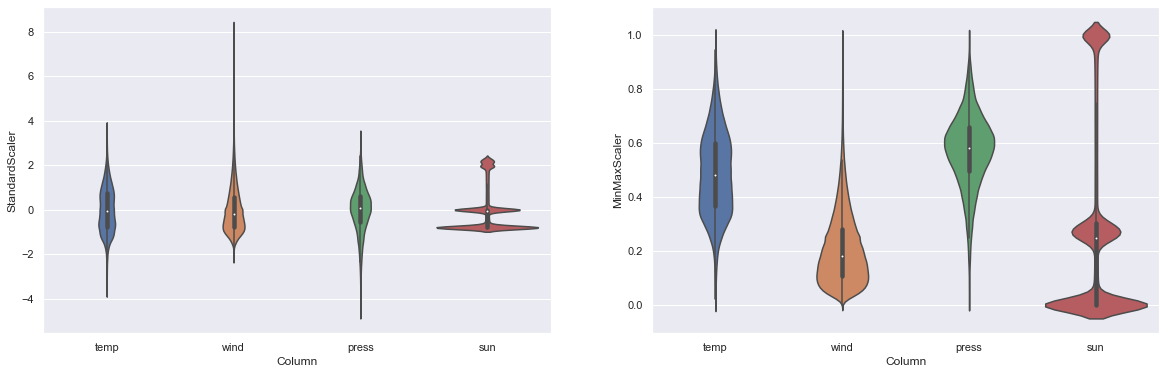

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standardize dataframe
df_std = pd.DataFrame(StandardScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Rescale / min-max normalize dataframe
df_scl = pd.DataFrame(MinMaxScaler().fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='StandardScaler',
               data=df_std.melt(var_name='Column', value_name='StandardScaler'))
_ = sns.violinplot(ax=axes[1], x='Column', y='MinMaxScaler',
                   data=df_scl.melt(var_name='Column', value_name='MinMaxScaler'))


C:\Users\luisg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


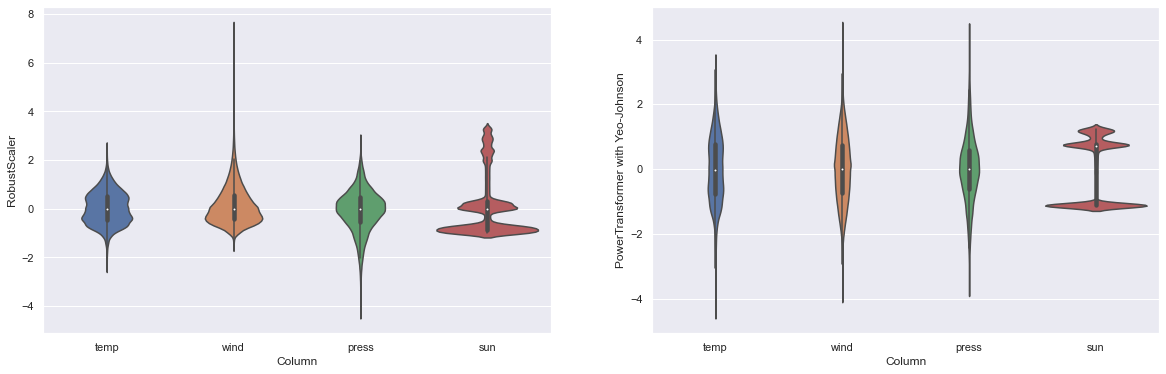

In [6]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Scale with the RobustScaler
df_rob = pd.DataFrame(RobustScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Transform to Gaussian Distribution with Yeo-Johnson
df_tyj = pd.DataFrame(PowerTransformer(method="yeo-johnson").fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='RobustScaler',
               data=df_rob.melt(var_name='Column', value_name='RobustScaler'))
_ = sns.violinplot(ax=axes[1], x='Column', y='PowerTransformer with Yeo-Johnson',
                   data=df_tyj.melt(var_name='Column', value_name='PowerTransformer with Yeo-Johnson'))


## Addition of noise to simulate forecast inaccuracy

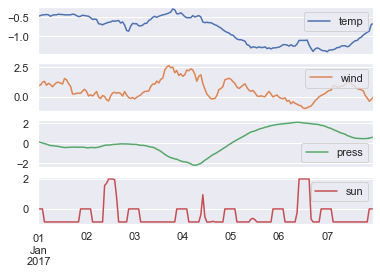

In [56]:
# Plot all parameters of one station over a week
station = "00183"
wx_week = df_rob.xs(station, level=1, axis=1).iloc[0:7*24]
_ = wx_week.plot(subplots=True)

Add Gaussian noise:

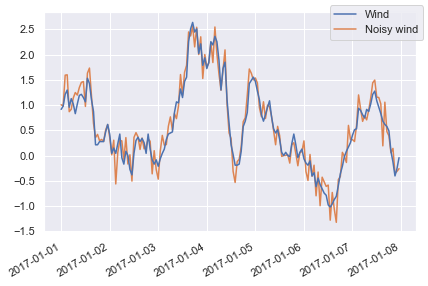

In [125]:
noise_factor = 0.2
wx_week_noisy = wx_week + noise_factor * np.random.normal(size=wx_week.shape)

# Plot wind as example
fig, ax = plt.subplots(figsize=(6, 4))
ax = plt.plot(wx_week["wind"], label="Wind")
ax = plt.plot(wx_week_noisy["wind"], label="Noisy wind", zorder=1)
fig.autofmt_xdate()
fig.legend()
fig.tight_layout()

Create a random walk time series:

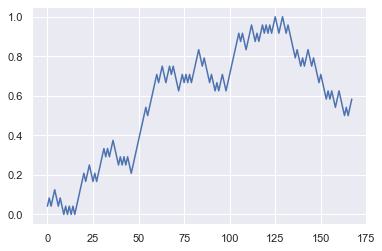

In [127]:
from random import seed
from random import random

seed(1)
random_walk = []
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, wx_week.shape[0]):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
# Scale the data
random_walk = MinMaxScaler().fit_transform(
    np.array(random_walk).reshape(-1, 1))
_ = plt.plot(random_walk)


Apply random walk to wind time series:

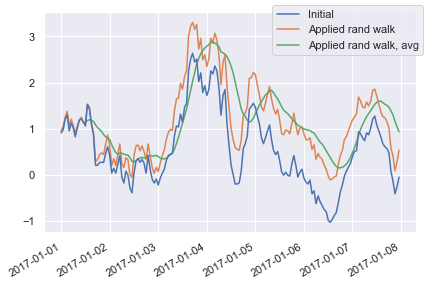

In [134]:
noise_factor = 1
wx_week_rw = wx_week + noise_factor * random_walk

fig, ax = plt.subplots(figsize=(6, 4))
ax = plt.plot(wx_week["wind"], label="Initial")
ax = plt.plot(wx_week_rw["wind"], label="Applied rand walk", zorder=1)
ax = plt.plot(wx_week_rw["wind"].rolling(12).mean(),
              label="Applied rand walk, avg", zorder=1)
fig.autofmt_xdate()
fig.legend()
fig.tight_layout()
